# 통신사 고객 이탈 예측 

### 목적
* 파악한 특성들을 이용하여 기대 가치가 큰 고객의 이탈 징후를 잘 탐지하는 예측 모델 생성.
[참고](https://brunch.co.kr/@gimmesilver/53)
    - 예측 모델의 목표는 오차를 최소화하는 것이 아니다.
        - 실제 서비스에서 예측 모델을 사용하는 본질적인 목적은 정답을 잘 맞추겠다가 아니라 예측 모델을 실전에 적용함으로써 이익을 얻는 것. 
        - 따라서, 실제 예측 모델이 목표로 해야할 것은 오차를 최소화하는 것이 아니라 모델 적용을 통해 기대되는 이익을 최대화하는 것. 
        
### 문제 정의
* 지도학습, 분류

### 성능 지표
* 재현율
    * 실제 이탈하는 사람 중 이탈이라고 예측하는 것이 중요하기 때문.
    * 실제 이탈하지 않은 사람을 이탈이라고 예측하면 회사 측에서 손해액 발생

In [316]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder  # 더미변수 생성 
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # 분류
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns


In [297]:
df = pd.read_csv("../../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.shape

(7043, 21)

In [298]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [299]:
X = df.drop(["Churn"],axis = 1)
y = df["Churn"]

In [300]:
y.replace("No",0,inplace = True)
y.replace("Yes",1,inplace = True)

In [290]:
y.value_counts()/len(y)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y,test_size = 0.2, shuffle = True, random_state = 20171490)

In [301]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5634, 20)
(1409, 20)
(5634,)
(1409,)


In [302]:
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

0    0.734647
1    0.265353
Name: Churn, dtype: float64
0    0.734564
1    0.265436
Name: Churn, dtype: float64


In [304]:
print(y_train.value_counts())
print(y_test.value_counts())

0    4139
1    1495
Name: Churn, dtype: int64
0    1035
1     374
Name: Churn, dtype: int64


#### train데이터로만 탐색

In [305]:
data_train = X_train

In [306]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 5658 to 1059
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   objec

In [307]:
data_train["SeniorCitizen"] = data_train["SeniorCitizen"].astype("object")
data_train["TotalCharges"] = pd.to_numeric(data_train["TotalCharges"],errors = 'coerce')

In [308]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 5658 to 1059
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   object 
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   objec

In [309]:
cate_features2 = []
cate_features_not2 = []

for column in data_train.columns:
    if data_train[column].dtypes==object:
        if len(data_train[column].value_counts())==2:
            cate_features2.append(column)
        else:
            cate_features_not2.append(column)
        
print(cate_features2)
print(cate_features_not2)

cate_features_not2.remove("customerID")

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [311]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [439]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["tenure", "MonthlyCharges"])),
        ("imputer", SimpleImputer(strategy="median")),
        ('scaler', RobustScaler()),
    ])

cate_1hot_pipeline = Pipeline([
        ("select_cate_1hot", DataFrameSelector(cate_features_not2)),
        ('1hot', OneHotEncoder(sparse=False)),  # sparse=False 밀집행렬로 만들어야함. 
    ])

cate_ord_pipeline = Pipeline([
        ("select_cate_ord", DataFrameSelector(cate_features2)),
        ('ordinary', OrdinalEncoder()),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_pipeline)])

# feature_processing = Pipeline([('feats', preprocess_pipeline)])

X_prepared = preprocess_pipeline.fit_transform(data_train)

In [440]:
pd.DataFrame(X_prepared)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,-0.106383,0.418144,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1,0.127660,0.276307,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.340426,0.080129,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.276596,-0.913654,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
4,-0.531915,-0.848262,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,-0.489362,-0.932075,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
5630,0.787234,-0.052498,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5631,0.787234,0.548008,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
5632,0.872340,0.363804,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


#### 파이프라인 적용 후 feature 확인

In [441]:
feature_names = cate_1hot_pipeline.named_steps["1hot"]
feature_names.categories_

[array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object)]

In [442]:
cat_one_hot_features = []

i = 0

for feature in cate_features_not2:
        
    cat_one_hot_features.append([feature+"_"+string for string in list(feature_names.categories_[i])])    

    i += 1
    
cat_one_hot_features = sum(cat_one_hot_features,[])
print(cat_one_hot_features)

features =  num_features+cat_one_hot_features+ cate_features2 
print()
print(len(features))

['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

39


In [445]:
X_prepared.shape

(5634, 39)

### 여러 모델 적용하여 비교하기 

In [446]:
models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","GB","Ada","XGB"]

from sklearn.model_selection import StratifiedKFold
cv_mo = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 20171490)

for model, name in zip(models, names):
    print(name)
    start = time.time()
    cv_predict = cross_val_predict(model, X_prepared, y_train,cv=cv_mo)

    print(classification_report(y_train, cv_predict))
    print("--------------------------------------")

Logistic
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4139
           1       0.65      0.55      0.60      1495

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.79      0.80      0.80      5634

--------------------------------------
RF
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4139
           1       0.61      0.49      0.54      1495

    accuracy                           0.78      5634
   macro avg       0.72      0.69      0.70      5634
weighted avg       0.77      0.78      0.77      5634

--------------------------------------
GB
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4139
           1       0.65      0.53      0.58      1495

    accuracy                           0.80      5634
   macro avg       0.75      0.71  

AdaBoost와 Logistic의 성능이 가장 좋음

#### 랜덤포레스트기로 중요 변수 확인

In [32]:
feature_importances = pd.DataFrame(RandomForestClassifier().fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

,importance
tenure,0.207441
MonthlyCharges,0.201000
Contract_Month-to-month,0.060925
OnlineSecurity_No,0.034036
gender,0.033720
InternetService_Fiber optic,0.033041
Partner,0.027970
PaperlessBilling,0.027919
TechSupport_No,0.026773
PaymentMethod_Electronic check,0.026260


<AxesSubplot:xlabel='importance'>

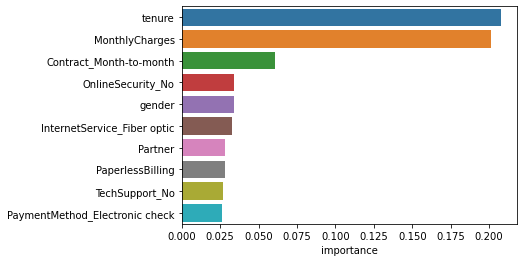

In [37]:
sns.barplot(feature_importances["importance"],feature_importances.index)

#### 보조 서비스 가입 개수 변수 추가하기
보조서비스 종류: OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport   
스트리밍: StreamingTV, StreamingMovies

In [542]:
# 열인덱스 

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names): # *args 또는 **kargs 없음
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        
        X[self.attribute_names] = X[self.attribute_names].replace("Yes",1)
        X[self.attribute_names] = X[self.attribute_names].replace("No",0)
        X[self.attribute_names] = X[self.attribute_names].replace("No internet service",0)
    
        X["SupplementaryService"] = X["OnlineSecurity"]+X["OnlineBackup"]+X["DeviceProtection"]+X["TechSupport"]
        X["Streaming"] = X["StreamingTV"]+X["StreamingMovies"]

        return X

In [595]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names): # *args 또는 **kargs 없음
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        
        df = X[self.attribute_names]
        df.replace("Yes",1,inplace=True)
        df.replace("No",0,inplace=True)
        df.replace("No internet service",0,inplace=True)
    
        df["SupplementaryService"] = df["OnlineSecurity"]+df["OnlineBackup"]+df["DeviceProtection"]+df["TechSupport"]
        df["Streaming"] = df["StreamingTV"]+df["StreamingMovies"]

        return df.drop(self.attribute_names, axis = 1)

In [599]:
col_names = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
df_extra_attribs = CombinedAttributesAdder(col_names)
df_extra_attribs.transform(data_train)

,SupplementaryService,Streaming
5658,0,2
995,2,0
2778,1,0
2675,0,0
660,0,0
...,...,...
2402,0,0
342,3,0
4265,1,2
3547,4,2


In [603]:
print(data_train.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'SupplementaryService', 'Streaming'],
      dtype='object')


In [611]:
cate_features_not2

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [741]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["tenure", "MonthlyCharges"])),
        ("imputer", SimpleImputer(strategy="median")),
        ('scaler', RobustScaler()),
    ])

cate_1hot_pipeline = Pipeline([
        ("select_cate_1hot", DataFrameSelector(["MultipleLines","InternetService","Contract","PaymentMethod"])),
        ('1hot', OneHotEncoder(sparse=False)),  # sparse=False 밀집행렬로 만들어야함. 
    ])

cate_ord_pipeline = Pipeline([
        ("select_cate_ord", DataFrameSelector(cate_features2)),
        ('ordinary', OrdinalEncoder()),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ('attribs_adder', CombinedAttributesAdder(col_names)),
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_pipeline)])

# feature_processing = Pipeline([('feats', preprocess_pipeline)])

X_prepared = preprocess_pipeline.fit_transform(data_train)
pd.DataFrame(X_prepared)


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,2.0,-0.106383,0.418144,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1,2.0,0.0,0.127660,0.276307,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,-0.340426,0.080129,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.276596,-0.913654,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,-0.531915,-0.848262,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0.0,0.0,-0.489362,-0.932075,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
5630,3.0,0.0,0.787234,-0.052498,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5631,1.0,2.0,0.787234,0.548008,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
5632,4.0,2.0,0.872340,0.363804,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


In [742]:
X_prepared.shape

(5634, 23)

In [743]:
models = [LogisticRegression(), RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1), GradientBoostingClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","GB","Ada","XGB"]

cv_mo = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 20171490)

for model, name in zip(models, names):
    print(name)
    start = time.time()
    
    # method{'predict’,'predict_proba’, 'predict_log_proba’, 'decision_function'}, default=’predict’
    cv_predict = cross_val_predict(model, X_prepared, y_train,cv=cv_mo)

    print(classification_report(y_train, cv_predict))
    print("--------------------------------------")

Logistic
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4139
           1       0.66      0.56      0.60      1495

    accuracy                           0.81      5634
   macro avg       0.75      0.73      0.74      5634
weighted avg       0.80      0.81      0.80      5634

--------------------------------------
RF
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      4139
           1       0.67      0.46      0.54      1495

    accuracy                           0.80      5634
   macro avg       0.75      0.69      0.71      5634
weighted avg       0.78      0.80      0.78      5634

--------------------------------------
GB
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      4139
           1       0.64      0.52      0.58      1495

    accuracy                           0.80      5634
   macro avg       0.74      0.71  

Ada와 로지스틱의 성능이 가장 좋음

In [744]:
print(cate_features2)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


In [745]:
cat_encoder = selector.named_transformers_["one_hot"]

cat_one_hot_features = []

i = 0
for feature in ["MultipleLines","InternetService","Contract","PaymentMethod"]:
    cat_one_hot_features.append([feature+"_"+string for string in list(cat_encoder.categories_[i])])    
    
    i+=1

cat_one_hot_features = sum(cat_one_hot_features,[])
print(cat_one_hot_features)

features = ["SupplementaryService","Streaming","tenure", "MonthlyChages",]+ cat_one_hot_features + cate_features2 

print(features)
print(len(features))

['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
['SupplementaryService', 'Streaming', 'tenure', 'MonthlyChages', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
23


In [746]:
feature_importances = pd.DataFrame(RandomForestClassifier().fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

,importance
MonthlyChages,0.248800
tenure,0.246678
SupplementaryService,0.062411
Contract_Month-to-month,0.057557
PaymentMethod_Electronic check,0.039248
Streaming,0.035143
InternetService_Fiber optic,0.034943
gender,0.034169
PaperlessBilling,0.030941
Partner,0.028088


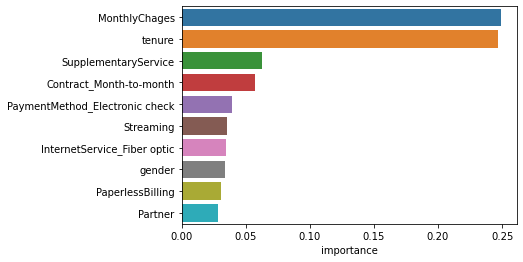

In [747]:
bar = sns.barplot(feature_importances["importance"],feature_importances.index)

In [624]:
param_grid_logistic = {
    "C":[0.25,0.5,0.75,1.0,1.5,2.0],
    "solver":["lbfgs", "sag", "saga"],
    "tol":[0.01,0.001],
    "penalty":["l1","l2"]}

cv_logistic = GridSearchCV(LogisticRegression(),param_grid_logistic, cv= cv_mo, scoring = "recall")
cv_logistic.fit(X_prepared, y_train)  # grid search 모델 
cv_logistic_best = cv_logistic.best_estimator_  # 가장 좋은 파라미터
print(cv_logistic_best)

LogisticRegression(C=0.75, tol=0.01)


In [625]:
cv_logistic.score(X_prepared, y_train)

0.5551839464882943

In [626]:
cv_predict = cross_val_predict(cv_logistic, X_prepared, y_train,cv=cv_mo)
print(classification_report(y_train, cv_predict))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4139
           1       0.66      0.56      0.60      1495

    accuracy                           0.81      5634
   macro avg       0.75      0.73      0.74      5634
weighted avg       0.80      0.81      0.80      5634



In [627]:
param_grid_logistic = {
    "C":[0.25,0.5,0.75,1.0,1.5,2.0],
    "solver":["lbfgs", "sag", "saga"],
    "tol":[0.01,0.001],
    "penalty":["l1","l2"]}

cv_logistic = GridSearchCV(LogisticRegression(),param_grid_logistic, cv= cv_mo, scoring = "roc_auc",)
cv_logistic.fit(X_prepared, y_train)  # grid search 모델 
cv_logistic_best = cv_logistic.best_estimator_  # 가장 좋은 파라미터
print(cv_logistic_best)

LogisticRegression(C=0.25, penalty='l1', solver='saga', tol=0.01)


In [628]:
cv_logistic.score(X_prepared, y_train)

0.8491905449509156

In [629]:
print(confusion_matrix(y_train,cv_logistic.predict(X_prepared)))
print(classification_report(y_train,cv_logistic.predict(X_prepared)))

[[3721  418]
 [ 675  820]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4139
           1       0.66      0.55      0.60      1495

    accuracy                           0.81      5634
   macro avg       0.75      0.72      0.74      5634
weighted avg       0.80      0.81      0.80      5634



In [630]:
pred = cross_val_predict(cv_logistic_best,X_prepared,y_train,cv = cv_mo)
print(classification_report(y_train,cv_logistic.predict(X_prepared)))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4139
           1       0.66      0.55      0.60      1495

    accuracy                           0.81      5634
   macro avg       0.75      0.72      0.74      5634
weighted avg       0.80      0.81      0.80      5634



#### RandomForest grid search

In [632]:
param_grid_RF = {
    "n_estimators" :[10,15,20,25,30], 
    "max_depth" : [5,10,15],
    "min_samples_split":[2,4,8,16],
    "max_features":["sqrt","auto","log2"],
    "class_weight" : ["balanced_subsample","balanced"]}

cv_RF_roc = GridSearchCV(RandomForestClassifier(),param_grid_RF, cv= cv_mo, scoring = "roc_auc",return_train_score=True)
cv_RF_roc.fit(X_prepared, y_train)
cv_RF_best = cv_RF_roc.best_estimator_

print(cv_RF.score(X_prepared, y_train))
print(confusion_matrix(cv_RF.predict(X_prepared),y_train))
print(classification_report(cv_RF.predict(X_prepared),y_train))

0.4101568326732986
[[3651 1463]
 [ 488   32]]
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      5114
           1       0.02      0.06      0.03       520

    accuracy                           0.65      5634
   macro avg       0.45      0.39      0.41      5634
weighted avg       0.80      0.65      0.72      5634



In [633]:
cv_RF_best

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=4, n_estimators=20)

In [635]:
model_Ada = AdaBoostClassifier(base_estimator = cv_RF_best, n_estimators = 4)
model_Ada.fit(X_prepared, y_train)
print(confusion_matrix(y_train,model_Ada.predict(X_prepared)))
print(classification_report(y_train,model_Ada.predict(X_prepared)))

[[3097 1042]
 [ 223 1272]]
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      4139
           1       0.55      0.85      0.67      1495

    accuracy                           0.78      5634
   macro avg       0.74      0.80      0.75      5634
weighted avg       0.83      0.78      0.79      5634



0.85로 재현율이 높은 편이나 정밀도가 너무 낮다고 여겨짐.

In [ ]:
y_scores = cross_val_predict(model_Ada, X_prepared, y_train, cv=cv_mo,method="decision_function")

In [636]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
thresholds

array([0, 1], dtype=int64)

In [638]:
len(thresholds)

2

In [639]:
precision_90_recall = precisions[np.argmax(recalls >= 0.90)]
threshold_90_precision = thresholds[np.argmax(recalls >= 0.90)]

In [640]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center left", fontsize=10) 
    plt.xlabel("Threshold", fontsize=13)        
    plt.grid(True)                              
    plt.axis([-20, 5, 0, 1])             

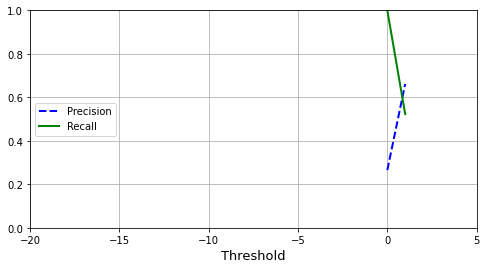

In [641]:
plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

0.6615905245346869
0.5230769230769231


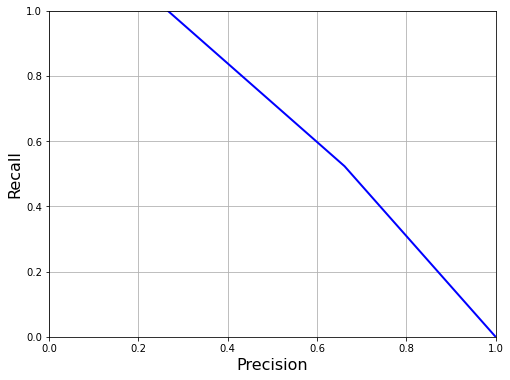

In [642]:
import matplotlib.pyplot as plt

def plot_precision_vs_recall(recalls, precisions):
    plt.plot(precisions,recalls, "b-", linewidth=2)
    plt.xlabel("Precision", fontsize=16)
    plt.ylabel("Recall", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(recalls, precisions)

threshold_80_recall = thresholds[np.argmax(recalls <= 0.80)]
threshold_80_recall

y_train_pred_80 = (y_scores >= threshold_80_recall)

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train, y_train_pred_80))
print(recall_score(y_train, y_train_pred_80))

In [709]:
print(cate_features2)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


In [710]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["tenure", "MonthlyCharges"])),
        ("imputer", SimpleImputer(strategy="median")),
        ('scaler', RobustScaler()),
    ])

cate_1hot_pipeline = Pipeline([
        ("select_cate_1hot", DataFrameSelector(['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod'])),
        ('1hot', OneHotEncoder(sparse=False)),  # sparse=False 밀집행렬로 만들어야함. 
    ])

cate_ord_pipeline = Pipeline([
        ("select_cate_ord", DataFrameSelector(['SeniorCitizen', 'Partner', 'Dependents','PaperlessBilling'])),
        ('ordinary', OrdinalEncoder()),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ('attribs_adder', CombinedAttributesAdder(col_names)),
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_pipeline)])

# feature_processing = Pipeline([('feats', preprocess_pipeline)])

X_prepared = preprocess_pipeline.fit_transform(data_train)
pd.DataFrame(X_prepared)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,2.0,-0.106383,0.418144,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,2.0,0.0,0.127660,0.276307,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,-0.340426,0.080129,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.276596,-0.913654,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.0,0.0,-0.531915,-0.848262,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0.0,0.0,-0.489362,-0.932075,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5630,3.0,0.0,0.787234,-0.052498,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5631,1.0,2.0,0.787234,0.548008,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
5632,4.0,2.0,0.872340,0.363804,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [711]:
models = [LogisticRegression(), RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1), GradientBoostingClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","GB","Ada","XGB"]

cv_mo = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 20171490)

for model, name in zip(models, names):
    print(name)
    start = time.time()
    
    # method{'predict’,'predict_proba’, 'predict_log_proba’, 'decision_function'}, default=’predict’
    cv_predict = cross_val_predict(model, X_prepared, y_train,cv=cv_mo)

    print(classification_report(y_train, cv_predict))
    print("--------------------------------------")

Logistic
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4139
           1       0.66      0.55      0.60      1495

    accuracy                           0.81      5634
   macro avg       0.75      0.73      0.74      5634
weighted avg       0.80      0.81      0.80      5634

--------------------------------------
RF
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4139
           1       0.67      0.46      0.55      1495

    accuracy                           0.80      5634
   macro avg       0.75      0.69      0.71      5634
weighted avg       0.78      0.80      0.78      5634

--------------------------------------
GB
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4139
           1       0.64      0.52      0.58      1495

    accuracy                           0.80      5634
   macro avg       0.74      0.71  

['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
['SupplementaryService', 'Streaming', 'tenure', 'MonthlyChages', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']
21


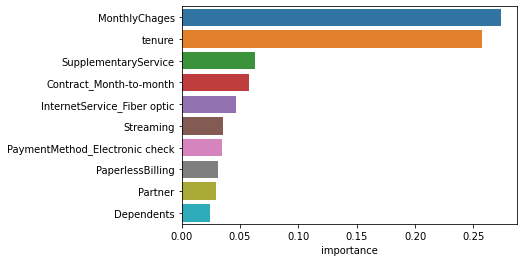

In [713]:
cat_encoder = selector.named_transformers_["one_hot"]

cat_one_hot_features = []

i = 0
for feature in ["MultipleLines","InternetService","Contract","PaymentMethod"]:
    cat_one_hot_features.append([feature+"_"+string for string in list(cat_encoder.categories_[i])])    
    
    i+=1

cat_one_hot_features = sum(cat_one_hot_features,[])
print(cat_one_hot_features)

features = ["SupplementaryService","Streaming","tenure", "MonthlyChages",]+ cat_one_hot_features + ['SeniorCitizen', 'Partner', 'Dependents','PaperlessBilling']

print(features)
print(len(features))

feature_importances = pd.DataFrame(RandomForestClassifier().fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

bar = sns.barplot(feature_importances["importance"],feature_importances.index)

#### 데이터가 불균형하기 때문에 업샘플링을 통해 비율을 맞춤. 

In [719]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 20171490)
X_res, y_res = sm.fit_sample(X_prepared, y_train)
print(y_train.value_counts(), np.bincount(y_res))

0    4139
1    1495
Name: Churn, dtype: int64 [4139 4139]


In [720]:
models = [LogisticRegression(), RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1), GradientBoostingClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","GB","Ada","XGB"]

for model, name in zip(models, names):
    print(name)
    start = time.time()
    
    # method{'predict’,'predict_proba’, 'predict_log_proba’, 'decision_function'}, default=’predict’
    cv_predict = cross_val_predict(model, X_res, y_res, cv=5)

    print(classification_report(y_res, cv_predict))
    print("--------------------------------------")

Logistic
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      4139
           1       0.75      0.80      0.78      4139

    accuracy                           0.77      8278
   macro avg       0.77      0.77      0.77      8278
weighted avg       0.77      0.77      0.77      8278

--------------------------------------
RF
              precision    recall  f1-score   support

           0       0.82      0.73      0.78      4139
           1       0.76      0.84      0.80      4139

    accuracy                           0.79      8278
   macro avg       0.79      0.79      0.79      8278
weighted avg       0.79      0.79      0.79      8278

--------------------------------------
GB
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      4139
           1       0.80      0.86      0.83      4139

    accuracy                           0.83      8278
   macro avg       0.83      0.83  

업샘플링을 통해 GB, XGB 의 성능이 올라감.

In [721]:
param_XGB = {"max_depth" : [3,4,5,6,7],
    "learning_rate" : [0.01, 0.05, 0.001],
    "booster" : ["gbtree","gblinear","dart"],
    "min_child_weight" : [1,3,5,7,9,11],
    "scale_pos_weight":[1,3,5]}

cv_xgb = GridSearchCV(XGBClassifier(),param_XGB, cv= 5, scoring = "roc_auc",return_train_score=True)
cv_xgb.fit(X_res, y_res)
cv_xgb_best_roc = cv_xgb.best_estimator_

print(cv_xgb.score(X_res, y_res))
print(confusion_matrix(y_res,cv_xgb.predict(X_res)))
print(classification_report(y_res,cv_xgb.predict(X_res)))

KeyboardInterrupt: 

In [ ]:
param_test = {"n_estimators": range(50, 100, 25), 
              "max_depth": [1, 2, 4], 
              "learning_rate": [0.0001, 0.001, 0.01, 0.1], 
              "subsample": [0.7, 0.9], 
              "max_features": list(range(1, len(X_res), 2)), }


cv_GB = GridSearchCV(GradientBoostingClassifier(),param_test, cv= cv_mo, scoring = "roc_auc",return_train_score=True)
cv_GB.fit(X_res, y_res)
cv_GB_best_roc = cv_GB.best_estimator_

print(cv_GB.score(X_res, y_res))
print(confusion_matrix(y_res,cv_GB.predict(X_res)))
print(classification_report(y_res,cv_GB.predict(X_res)))

In [650]:
X_test_prepared = preprocess_pipeline.fit_transform(X_test)

In [662]:
final_model = cv_xgb_best_roc
final_predictions = final_model.predict(X_test_prepared)
print(confusion_matrix(y_test,final_predictions))
print(classification_report(y_test,final_predictions))

[[781 254]
 [106 268]]
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1035
           1       0.51      0.72      0.60       374

    accuracy                           0.74      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.78      0.74      0.76      1409



In [717]:
feature_importances = pd.DataFrame(cv_xgb_best_roc.fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

,importance
Contract_Month-to-month,0.551265
InternetService_Fiber optic,0.194163
Contract_Two year,0.045371
InternetService_DSL,0.028898
Contract_One year,0.025962
tenure,0.017746
MultipleLines_No phone service,0.016445
Streaming,0.012007
PaperlessBilling,0.010763
MultipleLines_No,0.010100


<AxesSubplot:xlabel='importance'>

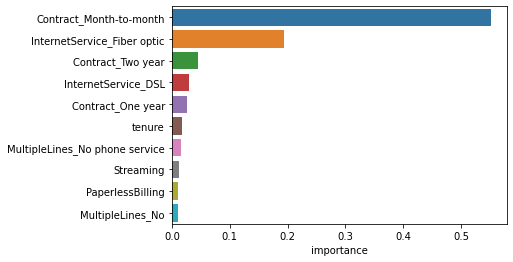

In [718]:
sns.barplot(feature_importances["importance"],feature_importances.index)

In [689]:
feature_importance = pd.DataFrame(final_model.feature_importances_,features)[0].sort_values(ascending = False)[:10]

In [695]:
feature_importance

Contract_Month-to-month        0.485180
InternetService_Fiber optic    0.146354
Contract_One year              0.055491
Contract_Two year              0.043068
PaperlessBilling               0.022978
Streaming                      0.022940
InternetService_No             0.019143
Partner                        0.018648
Dependents                     0.018337
tenure                         0.018280
Name: 0, dtype: float32

In [ ]:
# AdaBoost 확인 
model_Ada = AdaBoostClassifier(base_estimator = cv_RF_best, n_estimators = 4)
model_Ada.fit(X_prepared, y_train)
print(confusion_matrix(y_train,model_Ada.predict(X_prepared)))
print(classification_report(y_train,model_Ada.predict(X_prepared)))

In [655]:
Ada_final_predictions = model_Ada.predict(X_test_prepared)
print(confusion_matrix(y_test,Ada_final_predictions))
print(classification_report(y_test,Ada_final_predictions))

[[729 306]
 [ 77 297]]
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1035
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.74      1409



In [703]:
feature_importances = pd.DataFrame(model_Ada.fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

,importance
tenure,0.217597
MonthlyChages,0.163110
Contract_Month-to-month,0.116036
SupplementaryService,0.072064
Contract_Two year,0.054757
Streaming,0.035295
InternetService_Fiber optic,0.035126
PaymentMethod_Electronic check,0.033941
PaperlessBilling,0.031797
InternetService_No,0.028371


<AxesSubplot:xlabel='importance'>

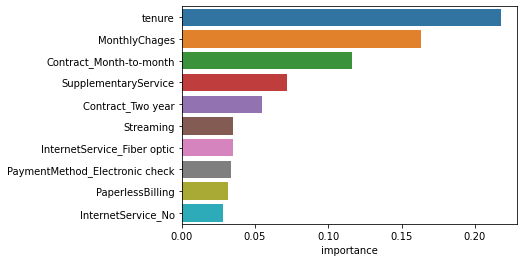

In [704]:
sns.barplot(feature_importances["importance"],feature_importances.index)

In [ ]:
# param_XGB = {"max_depth" : [3,4,5,6,7],
#     "learning_rate" : [0.01, 0.05, 0.001],
#     "booster" : ["gbtree","gblinear","dart"],
#     "min_child_weight" : [1,3,5,7,9,11],
#     "scale_pos_weight":[1,3,5]}

# cv_xgb = GridSearchCV(XGBClassifier(),param_XGB, cv= cv_mo, scoring = "recall")
# cv_xgb.fit(X_prepared, y_train)
# cv_xgb_best_recall = cv_xgb.best_estimator_

# print(cv_xgb.score(X_prepared, y_train))
# print(confusion_matrix(y_train,cv_xgb.predict(X_prepared)))
# print(classification_report(y_train,cv_xgb.predict(X_prepared)))

# param_XGB = {"max_depth" : [3,4,5,6,7],
#     "learning_rate" : [0.01, 0.05, 0.001],
#     "booster" : ["gbtree","gblinear","dart"],
#     "min_child_weight" : [1,3,5,7,9,11],
#     "scale_pos_weight":[1,3,5]}

# cv_xgb = GridSearchCV(XGBClassifier(),param_XGB, cv= cv_mo, scoring = "roc_auc")
# cv_xgb.fit(X_prepared, y_train)
# cv_xgb_best_roc = cv_xgb.best_estimator_

# print(cv_xgb.score(X_prepared, y_train))
# print(confusion_matrix(y_train,cv_xgb.predict(X_prepared)))
# print(classification_report(y_train,cv_xgb.predict(X_prepared)))

# # Dictionary of best parameters
# best_pars = cv_xgb.best_params_
# # Best XGB model that was found based on the metric score you specify
# best_model = cv_xgb.best_estimator_

# # Save model
# pickle.dump(cv_xgb.best_estimator_, open("xgb_clf.pickle", "wb"))

# best_model.fit(X_prepared,y_train)
# pred = best_model.predict(X_prepared)

# cv_predict_best = cross_val_predict(best_model, X_prepared, y_train,cv=cv_mo)

# print(confusion_matrix(y_train,cv_predict_best))
# print(classification_report(y_train,cv_predict_best))